In [1]:
from burstfit.fit import BurstFit
from burstfit.data import BurstData
from burstfit.model import Model, SgramModel
from burstfit.utils.plotter import plot_me
from burstfit.utils.functions import pulse_fn_vec, sgram_fn_vec, gauss_norm
from burstfit.io import BurstIO
import logging

In [2]:
logging_format = "%(asctime)s - %(funcName)s -%(name)s - %(levelname)s - %(message)s"
# using debug mode and turning OFF debug logging for matplotlib 
logging.basicConfig(
    level=logging.DEBUG,
    format=logging_format,
)
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.INFO)

# Get candidate cutout and preprocess

### BurstData class

In [3]:
fil_file = '../tests/data/tcand_2_dm_565.30000_snr_11.92560.fil'

In [4]:
bd = BurstData(
    fp=fil_file,
    dm=565.3,
    tcand=2,
    width=64,
    snr=11.9,
    min_samp=256,
)

2021-03-12 19:37:10,474 - __init__ -your.your - DEBUG - Reading the file(s): ../tests/data/tcand_2_dm_565.30000_snr_11.92560.fil
2021-03-12 19:37:10,477 - read_header -root - DEBUG - Reading b'HEADER_START' from the Filterbank file header.
2021-03-12 19:37:10,478 - read_header -root - DEBUG - Reading parameter (b'rawdatafile', 15) from the Filterbank file header.
2021-03-12 19:37:10,478 - read_header -root - DEBUG - Reading parameter (b'source_name', 15) from the Filterbank file header.
2021-03-12 19:37:10,479 - read_header -root - DEBUG - Reading parameter (b'machine_id', 14) from the Filterbank file header.
2021-03-12 19:37:10,479 - read_header -root - DEBUG - Reading parameter (b'barycentric', 15) from the Filterbank file header.
2021-03-12 19:37:10,480 - read_header -root - DEBUG - Reading parameter (b'pulsarcentric', 17) from the Filterbank file header.
2021-03-12 19:37:10,480 - read_header -root - DEBUG - Reading parameter (b'telescope_id', 16) from the Filterbank file header.
20

#### Crop the relevant time window. Dedisperse the data. Normalise the data to zero mean and unit standard deviation. Apply RFI masks (if any) and RFI filtering (if activated). 

In [5]:
# We will mask channel numbers from 53 to 64 as they are 0. 
bd.prepare_data(mask_chans=[(53, 64)])

2021-03-12 19:37:10,557 - prepare_data -burstfit.data - INFO - Preparing data for burst fitting.
2021-03-12 19:37:10,558 - get_chunk -your.candidate - DEBUG - tstart is 0.3321920493439991
2021-03-12 19:37:10,558 - get_chunk -your.candidate - DEBUG - tstop is 3.667807950656001
2021-03-12 19:37:10,559 - get_chunk -root - DEBUG - nstart_read is 4055, nsamp_read is 40717,nstart is 4055, nsamp is 40717
2021-03-12 19:37:10,559 - get_chunk -root - DEBUG - All the data available in the file, no need to pad. 
nstart_read(4055)>=0 and 
nstart_read(4055)+nsamp_read(40717)<=nspectra(48828)
2021-03-12 19:37:10,560 - get_data -your.your - DEBUG - Reading 40717 samples from sample 4055
2021-03-12 19:37:10,561 - get_data -your.your - DEBUG - time_decimation_factor: 1
2021-03-12 19:37:10,561 - get_data -your.your - DEBUG - frequency_decimation_factor: 1
2021-03-12 19:37:10,610 - prepare_input_mask -burstfit.data - DEBUG - Preparing input mask.
2021-03-12 19:37:10,611 - mask_channels -burstfit.data - DE

Using <class 'str'>:
../tests/data/tcand_2_dm_565.30000_snr_11.92560.fil

#### Here is the burst

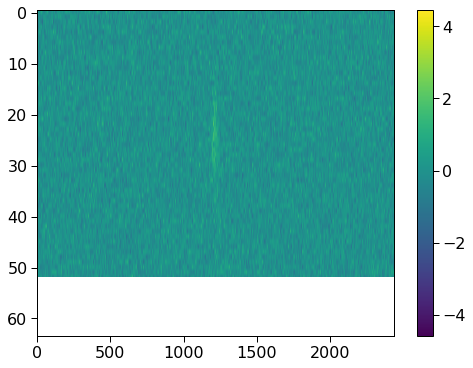

In [6]:
plot_me(bd.sgram)

# Fitting using BurstFit

#### BurstFit fits the spectrogram. It requires three functions: profile function, spectra function and spectrogram function. It is assumed that spectrogram function will use profile and spectra functions to make the spectrogram.   

#### Use the Model class to make profile and spectra models and give names to input parameters. 

In [7]:
# For pulse, we will use a gaussian convolved with an exponential model 
pnames = ['S', 'mu_t', 'sigma_t', 'tau']
pulseModel = Model(pulse_fn_vec, param_names=pnames)

# For spectra, we will use a normalized gaussian model  
snames = ['mu_f', 'sigma_f']
spectraModel = Model(gauss_norm, param_names=snames)

#### Now we create a SgramModel using the above two models

In [8]:
sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
                        mask=bd.mask, clip_fac=bd.clip_fac)

#### Provide basic candidate information to BurstFit: sgram, model, DM, width, RFI mask, etc 

In [9]:
bf = BurstFit(
    sgram_model=sgramModel,
    sgram=bd.sgram,
    width=bd.width,
    dm=bd.dm,
    foff=bd.foff,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask=bd.mask) 

In [10]:
# Some setting up before we do the fitting 
bf.validate()
bf.precalc()

2021-03-12 19:37:11,364 - precalc -burstfit.fit - DEBUG - Running precalculations for component: 1
2021-03-12 19:37:11,365 - precalc -burstfit.fit - DEBUG - Setting sgram_model attributes.


### In Burstfit, the fitting procedure for each component is as follows: 
#### 1. Fit the profile using curve_fit
#### 2. Find the spectra using profile fit, and fit the spectra using curve_fit
#### 3. Fit the spectrogram using curve_fit

#### So, let's fit for one component

In [11]:
plot = True

2021-03-12 19:37:11,519 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2021-03-12 19:37:11,520 - initial_profilefit -burstfit.fit - DEBUG - Bounds for profile fit are: ([0, 964, 0, 0], [3177.6240234375, 1476, 256, 256])
2021-03-12 19:37:11,560 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2021-03-12 19:37:11,561 - initial_profilefit -burstfit.fit - INFO - S: 763.9470222396869 +- 76.47155802814272
2021-03-12 19:37:11,562 - initial_profilefit -burstfit.fit - INFO - mu_t: 1202.832588161036 +- 3.3843576775928397
2021-03-12 19:37:11,562 - initial_profilefit -burstfit.fit - INFO - sigma_t: 11.487928835362144 +- 2.863860070777841
2021-03-12 19:37:11,563 - initial_profilefit -burstfit.fit - INFO - tau: 15.684895946500633 +- 6.35034474880263


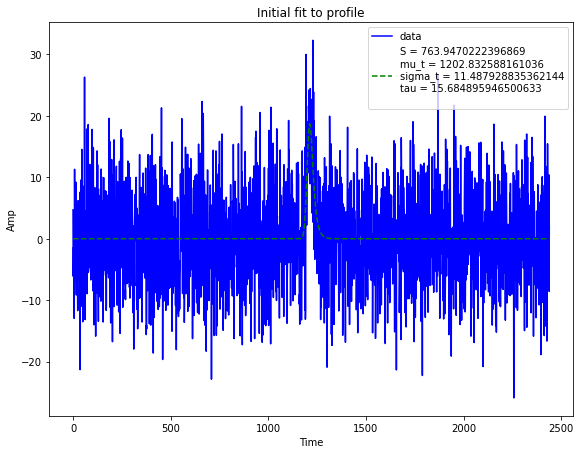

In [12]:
bf.initial_profilefit(plot=plot)

In [13]:
bf.make_spectra()

2021-03-12 19:37:11,912 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-03-12 19:37:11,913 - make_spectra -burstfit.fit - DEBUG - Generating spectra from sample 1189 to 1230
2021-03-12 19:37:11,914 - make_spectra -burstfit.fit - DEBUG - Normalising spectra to unit area.


2021-03-12 19:37:11,983 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-03-12 19:37:11,983 - initial_spectrafit -burstfit.fit - DEBUG - Bounds for spectra fit are: ([0, 0], [63, 63])
2021-03-12 19:37:11,990 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-03-12 19:37:11,990 - initial_spectrafit -burstfit.fit - INFO - mu_f: 24.478044459914074 +- 0.40858355670038715
2021-03-12 19:37:11,991 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 5.876907075384988 +- 0.3336071378032658


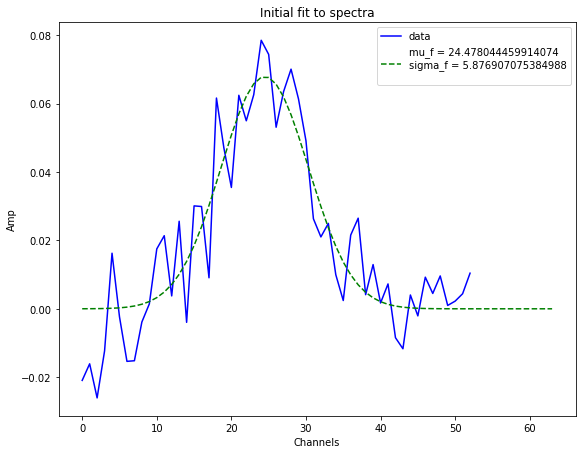

In [14]:
bf.initial_spectrafit(plot=plot)

2021-03-12 19:37:12,247 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-03-12 19:37:12,248 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [24.478044459914074, 5.876907075384988, 763.9470222396869, 1202.832588161036, 11.487928835362144, 15.684895946500633, 565.3]
2021-03-12 19:37:12,793 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-03-12 19:37:12,794 - sgram_fit -burstfit.fit - INFO - mu_f: 24.975849003327195 +- 0.3914311686459791
2021-03-12 19:37:12,795 - sgram_fit -burstfit.fit - INFO - sigma_f: 6.166294966919394 +- 0.3834043551301487
2021-03-12 19:37:12,795 - sgram_fit -burstfit.fit - INFO - S: 731.2832079635614 +- 48.013029647860286
2021-03-12 19:37:12,796 - sgram_fit -burstfit.fit - INFO - mu_t: 1207.2991214508688 +- 4.213243536228096
2021-03-12 19:37:12,796 - sgram_fit -burstfit.fit - INFO - sigma_t: 11.259609732524533 +- 1.5688742150501045
2021-03-12 19:37:12,797 - sgram_fit -burstfit.fit - INFO - tau: 6.

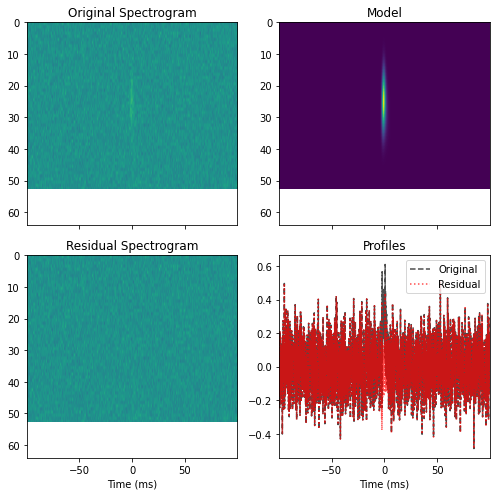

2021-03-12 19:37:13,564 - model -burstfit.fit - INFO - Making model.
2021-03-12 19:37:13,564 - model -burstfit.fit - INFO - Found 1 components.


In [15]:
bf.sgram_fit(plot=plot)

In [16]:
bf.calc_redchisq()

2021-03-12 19:37:13,578 - calc_redchisq -burstfit.fit - DEBUG - Estimating reduced chi square value of the fit.
2021-03-12 19:37:13,579 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-03-12 19:37:13,579 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-03-12 19:37:13,582 - calc_redchisq -burstfit.fit - DEBUG - Standard deviation is 1.0000229904160622
2021-03-12 19:37:13,583 - model -burstfit.fit - INFO - Making model.
2021-03-12 19:37:13,584 - model -burstfit.fit - INFO - Found 1 components.
2021-03-12 19:37:13,596 - calc_redchisq -burstfit.fit - DEBUG - Unmasked data size is 129320
2021-03-12 19:37:13,596 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 0.9957156205218006


0.9957156205218006

### All the above steps can be called using fitcycle() 

2021-03-12 19:37:13,642 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2021-03-12 19:37:13,643 - precalc -burstfit.fit - DEBUG - Running precalculations for component: 1
2021-03-12 19:37:13,645 - precalc -burstfit.fit - DEBUG - Setting sgram_model attributes.
2021-03-12 19:37:13,645 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2021-03-12 19:37:13,646 - initial_profilefit -burstfit.fit - DEBUG - Bounds for profile fit are: ([0, 964, 0, 0], [3177.6240234375, 1476, 256, 256])
2021-03-12 19:37:13,689 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2021-03-12 19:37:13,690 - initial_profilefit -burstfit.fit - INFO - S: 763.9470222396869 +- 76.47155802814272
2021-03-12 19:37:13,691 - initial_profilefit -burstfit.fit - INFO - mu_t: 1202.832588161036 +- 3.3843576775928397
2021-03-12 19:37:13,692 - initial_profilefit -burstfit.fit - INFO - sigma_t: 11.487928835362144 +- 2.863860070777841
2021-03-12 19:37:13,6

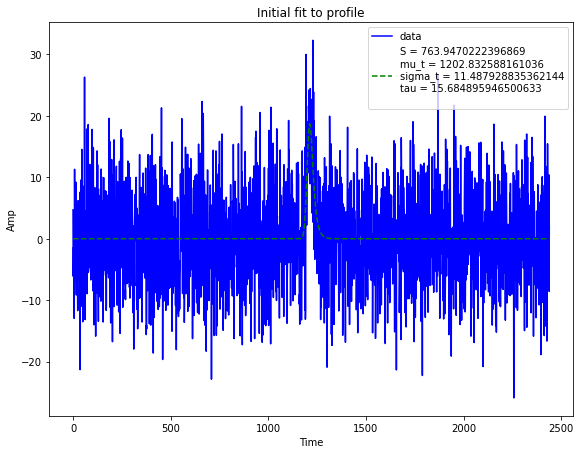

2021-03-12 19:37:14,047 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-03-12 19:37:14,048 - make_spectra -burstfit.fit - DEBUG - Generating spectra from sample 1189 to 1230
2021-03-12 19:37:14,049 - make_spectra -burstfit.fit - DEBUG - Normalising spectra to unit area.
2021-03-12 19:37:14,050 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-03-12 19:37:14,050 - initial_spectrafit -burstfit.fit - DEBUG - Bounds for spectra fit are: ([0, 0], [63, 63])
2021-03-12 19:37:14,056 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-03-12 19:37:14,056 - initial_spectrafit -burstfit.fit - INFO - mu_f: 24.478044459914074 +- 0.40858355670038715
2021-03-12 19:37:14,057 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 5.876907075384988 +- 0.3336071378032658


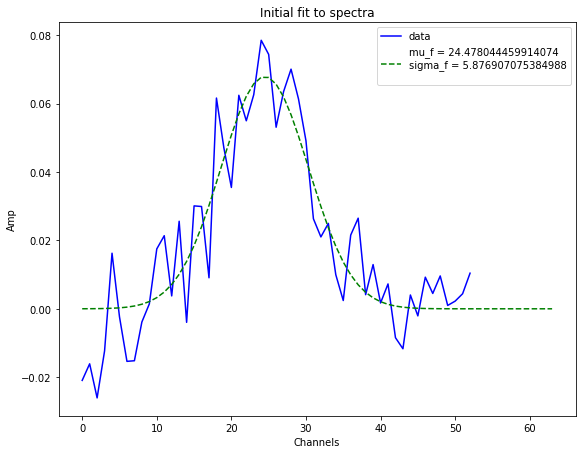

2021-03-12 19:37:14,373 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-03-12 19:37:14,373 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [24.478044459914074, 5.876907075384988, 763.9470222396869, 1202.832588161036, 11.487928835362144, 15.684895946500633, 565.3]
2021-03-12 19:37:14,931 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-03-12 19:37:14,932 - sgram_fit -burstfit.fit - INFO - mu_f: 24.975849003327195 +- 0.3914311686459791
2021-03-12 19:37:14,932 - sgram_fit -burstfit.fit - INFO - sigma_f: 6.166294966919394 +- 0.3834043551301487
2021-03-12 19:37:14,933 - sgram_fit -burstfit.fit - INFO - S: 731.2832079635614 +- 48.013029647860286
2021-03-12 19:37:14,933 - sgram_fit -burstfit.fit - INFO - mu_t: 1207.2991214508688 +- 4.213243536228096
2021-03-12 19:37:14,933 - sgram_fit -burstfit.fit - INFO - sigma_t: 11.259609732524533 +- 1.5688742150501045
2021-03-12 19:37:14,934 - sgram_fit -burstfit.fit - INFO - tau: 6.

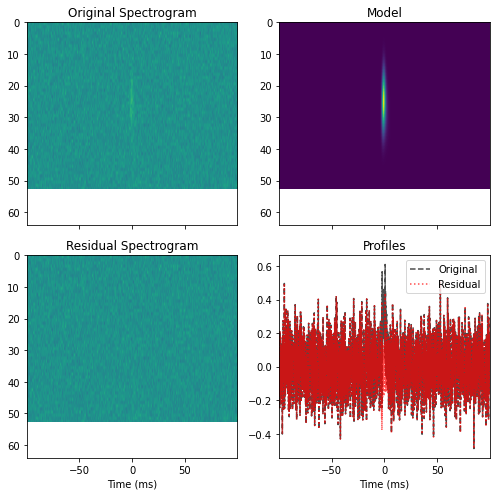

2021-03-12 19:37:15,702 - model -burstfit.fit - INFO - Making model.
2021-03-12 19:37:15,703 - model -burstfit.fit - INFO - Found 1 components.
2021-03-12 19:37:15,712 - calc_redchisq -burstfit.fit - DEBUG - Estimating reduced chi square value of the fit.
2021-03-12 19:37:15,713 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-03-12 19:37:15,713 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-03-12 19:37:15,716 - calc_redchisq -burstfit.fit - DEBUG - Standard deviation is 1.0000229904160622
2021-03-12 19:37:15,716 - model -burstfit.fit - INFO - Making model.
2021-03-12 19:37:15,716 - model -burstfit.fit - INFO - Found 1 components.
2021-03-12 19:37:15,729 - calc_redchisq -burstfit.fit - DEBUG - Unmasked data size is 129320
2021-03-12 19:37:15,729 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 0.9957156205218006


In [17]:
bf.fitcycle(plot=True)

#### But fitcycle only fits for one component. BurstFit can automatically fit for all the components as well. For that we will use fitall()

#### Here it calls fitcycle() to fit for a component and then compares the ON-pulse residual with the OFF pulse regions (both left and right). If the distributions are similar then fitting is terminated. If the distributions aren't similar, then it tries to fit for another component. In the end, it will fit for all the components together. 

2021-03-12 19:37:15,735 - precalc -burstfit.fit - DEBUG - Running precalculations for component: 1
2021-03-12 19:37:15,736 - precalc -burstfit.fit - DEBUG - Setting sgram_model attributes.
2021-03-12 19:37:15,736 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-03-12 19:37:15,737 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-03-12 19:37:15,745 - tests -root - INFO - P values: T-test (0.60679), Kruskal (0.70429), KS (0.87426), F-test (0.61511)
2021-03-12 19:37:15,746 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2021-03-12 19:37:15,754 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00000), F-test (0.00044)
2021-03-12 19:37:15,754 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2021-03-12 19:37:15,762 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00001), F-test (0.00015)
2021-03-12 19:37:15,762 - fitcycle -burstfit.f

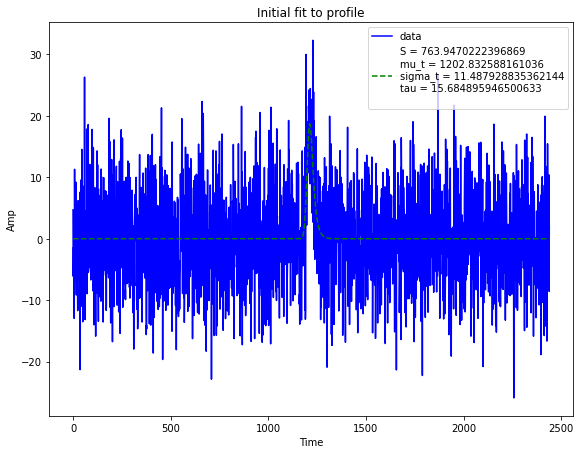

2021-03-12 19:37:16,155 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-03-12 19:37:16,156 - make_spectra -burstfit.fit - DEBUG - Generating spectra from sample 1189 to 1230
2021-03-12 19:37:16,157 - make_spectra -burstfit.fit - DEBUG - Normalising spectra to unit area.
2021-03-12 19:37:16,157 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-03-12 19:37:16,158 - initial_spectrafit -burstfit.fit - DEBUG - Bounds for spectra fit are: ([0, 0], [63, 63])
2021-03-12 19:37:16,163 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-03-12 19:37:16,164 - initial_spectrafit -burstfit.fit - INFO - mu_f: 24.478044459914074 +- 0.40858355670038715
2021-03-12 19:37:16,164 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 5.876907075384988 +- 0.3336071378032658


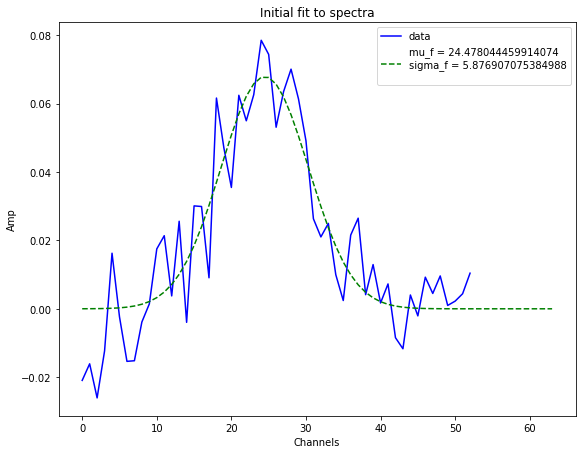

2021-03-12 19:37:16,411 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-03-12 19:37:16,412 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [24.478044459914074, 5.876907075384988, 763.9470222396869, 1202.832588161036, 11.487928835362144, 15.684895946500633, 565.3]
2021-03-12 19:37:16,954 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-03-12 19:37:16,955 - sgram_fit -burstfit.fit - INFO - mu_f: 24.975849003327195 +- 0.3914311686459791
2021-03-12 19:37:16,955 - sgram_fit -burstfit.fit - INFO - sigma_f: 6.166294966919394 +- 0.3834043551301487
2021-03-12 19:37:16,956 - sgram_fit -burstfit.fit - INFO - S: 731.2832079635614 +- 48.013029647860286
2021-03-12 19:37:16,956 - sgram_fit -burstfit.fit - INFO - mu_t: 1207.2991214508688 +- 4.213243536228096
2021-03-12 19:37:16,956 - sgram_fit -burstfit.fit - INFO - sigma_t: 11.259609732524533 +- 1.5688742150501045
2021-03-12 19:37:16,957 - sgram_fit -burstfit.fit - INFO - tau: 6.

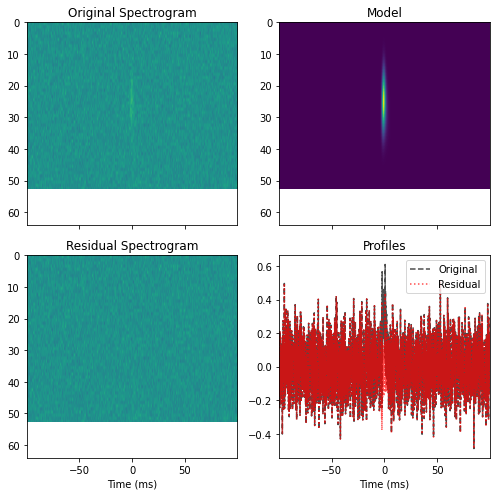

2021-03-12 19:37:17,723 - model -burstfit.fit - INFO - Making model.
2021-03-12 19:37:17,724 - model -burstfit.fit - INFO - Found 1 components.
2021-03-12 19:37:17,733 - calc_redchisq -burstfit.fit - DEBUG - Estimating reduced chi square value of the fit.
2021-03-12 19:37:17,734 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-03-12 19:37:17,734 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-03-12 19:37:17,736 - calc_redchisq -burstfit.fit - DEBUG - Standard deviation is 1.0000229904160622
2021-03-12 19:37:17,737 - model -burstfit.fit - INFO - Making model.
2021-03-12 19:37:17,737 - model -burstfit.fit - INFO - Found 1 components.
2021-03-12 19:37:17,749 - calc_redchisq -burstfit.fit - DEBUG - Unmasked data size is 129320
2021-03-12 19:37:17,750 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 0.9957156205218006
2021-03-12 19:37:17,750 - run_tests -bur

In [18]:
bf.fitall(plot=True)

In [19]:
bf.sgram_params['all']

{1: {'popt': [24.975849003327195,
   6.166294966919394,
   731.2832079635614,
   1207.2991214508688,
   11.259609732524533,
   6.132069921186363,
   564.3361968307069],
  'perr': array([ 0.39143117,  0.38340436, 48.01302965,  4.21324354,  1.56887422,
          1.62351806,  0.52390598])}}

#### Now, to save the fitting results we can use BurstIO class. See this notebook.  